In [42]:
import torch
import torch.nn.functional as F
import math

inputs = {
    "prompt_ids": torch.randint(0, 10, (2, 10)),
    "prompt_mask": torch.ones(2, 10),
    "completion_ids": torch.randint(0, 8, (2, 8)),
    "completion_mask": torch.ones(2, 8)
}

prompt_ids, prompt_mask = inputs["prompt_ids"], inputs["prompt_mask"]
completion_ids, completion_mask = inputs["completion_ids"], inputs["completion_mask"]

如下即得到一次前向的 tokens 结果，也是 RL 范式上的 discrete action sequence，也是目标函数的输入。

In [37]:
input_ids = torch.cat([prompt_ids, completion_ids], dim=1)
mask = torch.cat([prompt_mask, completion_mask], dim=1)

input_ids, mask

(tensor([[7, 8, 5, 7, 5, 5, 3, 9, 0, 1, 2, 5, 1, 6, 4, 7, 6, 5],
         [0, 3, 4, 7, 3, 9, 6, 2, 8, 1, 2, 0, 5, 1, 0, 5, 5, 4]]),
 tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]]))

基于 LSTM 的简易的语言模型和奖励模型。

In [43]:
class SimpleLanguageModel(torch.nn.Module):
    def __init__(self, vocab_size=10, hidden_dim=64):
        super().__init__()
        self.embedding = torch.nn.Embedding(vocab_size, 32)
        self.lstm = torch.nn.LSTM(32, hidden_dim, batch_first=True)
        self.lm_head = torch.nn.Linear(hidden_dim, vocab_size)
    
    def forward(self, input_ids):
        embeddings = self.embedding(input_ids)
        lstm_out, _ = self.lstm(embeddings)
        logits = self.lm_head(lstm_out)
        return logits

class RewardModel(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.embedding = torch.nn.Embedding(10, 32)
        self.lstm = torch.nn.LSTM(32, hidden_size=64, num_layers=2, batch_first=True)
        self.head = torch.nn.Linear(64, 1)

    def forward(self, prompt_ids, completion_ids):
        full_ids = torch.cat([prompt_ids, completion_ids], dim=1)
        embeddings = self.embedding(full_ids)
        lstm_out, _ = self.lstm(embeddings)
        final_hidden = lstm_out[:, -1, :]
        reward = self.head(final_hidden).squeeze(-1)
        return reward

policy_model = SimpleLanguageModel()
old_policy_model = SimpleLanguageModel()
reward_model = RewardModel()

从 PPO 到 GRPO，再到 GSPO 的目标函数公式实现。重点在于统计 token 和 sequence 上的优势，可以是整体共享的优势值，基于 GAE 计算（PPO）；也可以是按 sequence reward bias 不同计算的不同 sequence 的优势（GRPO）；也可以是按重要性比例进行代数、几何平均都是可以的，实际上重要性比例在当前的位置和 A 是平起平坐的，类似动量。

$$\mathcal{J}_{\mathrm{PPO}}(\theta)=\mathbb{E}_{x \sim \mathcal{D}, y \sim \pi_{\theta_{\text {old }}}(\cdot \mid x)}\left[\frac{1}{|y|} \sum_{t=1}^{|y|} \min \left(w_{t}(\theta) \widehat{A}_{t}, \operatorname{clip}\left(w_{t}(\theta), 1-\varepsilon, 1+\varepsilon\right) \widehat{A}_{t}\right)\right]$$
$$w_{t}(\theta)=\frac{\pi_{\theta}\left(y_{t} \mid x, y_{<t}\right)}{\pi_{\theta_{\text {old }}}\left(y_{t} \mid x, y_{<t}\right)}$$


In [75]:
import torch
import torch.nn.functional as F

eps = 0.2
log_probs = F.log_softmax(torch.randn(2, 8), dim=1)
old_log_probs = F.log_softmax(torch.randn(2, 8), dim=1)
advantages = torch.randn(2, 8)

ratio = (log_probs - old_log_probs).exp()
surr1 = ratio * advantages
surr2 = torch.clamp(ratio, 1 - eps, 1 + eps) * advantages

-torch.min(surr1, surr2).mean(dim=0)

tensor([ 0.5841, -1.3074, -1.1147,  1.2583, -0.6763,  0.1879,  0.2736, -0.4782])

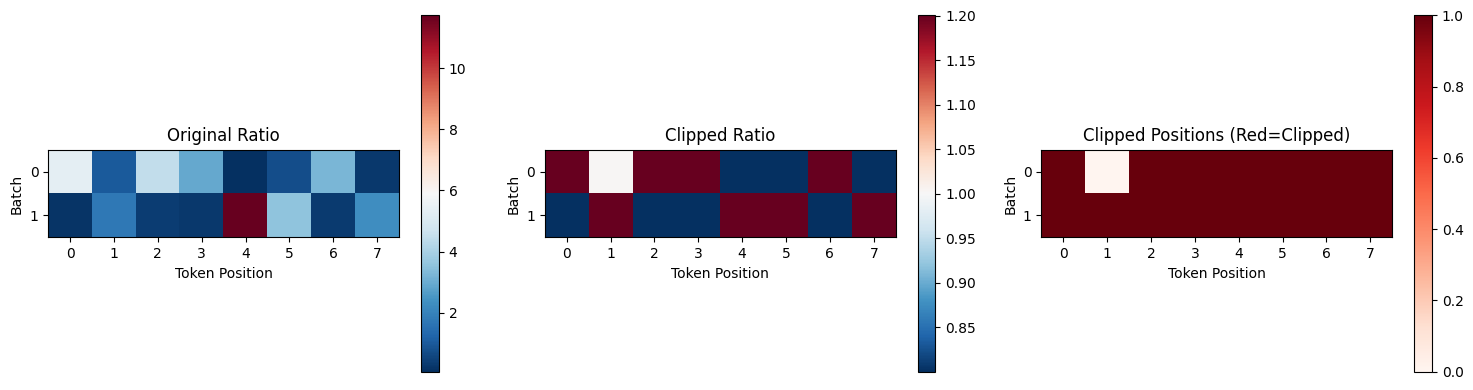

Clipping range: [0.8, 1.2]
Original ratio:
tensor([[ 5.3378,  1.0024,  4.4514,  2.9148,  0.0768,  0.7227,  3.2507,  0.2723],
        [ 0.2126,  1.7434,  0.3874,  0.3027, 11.7231,  3.5496,  0.3389,  2.3006]])

Clipped ratio:
tensor([[1.2000, 1.0024, 1.2000, 1.2000, 0.8000, 0.8000, 1.2000, 0.8000],
        [0.8000, 1.2000, 0.8000, 0.8000, 1.2000, 1.2000, 0.8000, 1.2000]])


In [76]:
import matplotlib.pyplot as plt
import numpy as np

# Visualize ratio and clipped ratio
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 4))

# Original ratio
ratio_np = ratio.detach().numpy()
im1 = ax1.imshow(ratio_np, cmap='RdBu_r', aspect='equal')
ax1.set_title('Original Ratio')
ax1.set_xlabel('Token Position')
ax1.set_ylabel('Batch')
plt.colorbar(im1, ax=ax1)

# Clipped ratio
clipped_ratio = torch.clamp(ratio, 1 - eps, 1 + eps)
clipped_ratio_np = clipped_ratio.detach().numpy()
im2 = ax2.imshow(clipped_ratio_np, cmap='RdBu_r', aspect='equal')
ax2.set_title('Clipped Ratio')
ax2.set_xlabel('Token Position')
ax2.set_ylabel('Batch')
plt.colorbar(im2, ax=ax2)

# Show clipped positions
clipped_mask = (ratio != clipped_ratio).float().detach().numpy()
im3 = ax3.imshow(clipped_mask, cmap='Reds', aspect='equal')
ax3.set_title('Clipped Positions (Red=Clipped)')
ax3.set_xlabel('Token Position')
ax3.set_ylabel('Batch')
plt.colorbar(im3, ax=ax3)

plt.tight_layout()
plt.show()

print(f"Clipping range: [{1-eps:.1f}, {1+eps:.1f}]")
print("Original ratio:")
print(ratio)
print("\nClipped ratio:")
print(clipped_ratio)

$$\mathcal{J}_{\mathrm{GRPO}}(\theta)=\mathbb{E}_{x \sim \mathcal{D},\left\{y_{i}\right\}_{i=1}^{G} \sim \pi_{\theta_{\text {old }}}(\cdot \mid x)}\left[\frac{1}{G} \sum_{i=1}^{G} \frac{1}{\left|y_{i}\right|} \sum_{t=1}^{\left|y_{i}\right|} \min \left(w_{i, t}(\theta) \widehat{A}_{i, t}, \operatorname{clip}\left(w_{i, t}(\theta), 1-\varepsilon, 1+\varepsilon\right) \widehat{A}_{i, t}\right)\right]$$
$$w_{i, t}(\theta)=\frac{\pi_{\theta}\left(y_{i, t} \mid x, y_{i,<t}\right)}{\pi_{\theta_{\text {old }}}\left(y_{i, t} \mid x, y_{i,<t}\right)}, \quad \widehat{A}_{i, t}=\widehat{A}_{i}=\frac{r\left(x, y_{i}\right)-\operatorname{mean}\left(\left\{r\left(x, y_{i}\right)\right\}_{i=1}^{G}\right)}{\operatorname{std}\left(\left\{r\left(x, y_{i}\right)\right\}_{i=1}^{G}\right)}$$

In [85]:
import torch
import torch.nn.functional as F

eps = 0.2
log_probs = F.log_softmax(torch.randn(2, 8), dim=1)
old_log_probs = F.log_softmax(torch.randn(2, 8), dim=1)

rewards = torch.randn(2, 1)
rewards = (rewards - rewards.mean(dim=0)) / (rewards.std(dim=0) + 1e-6)
advantages = rewards.expand(size=(2, 8))

ratio = (log_probs - old_log_probs).exp()
surr1 = ratio * advantages
surr2 = torch.clamp(ratio, 1 - eps, 1 + eps) * advantages

-torch.min(surr1, surr2).mean()

tensor(0.1629)